In [ ]:
# importing Necessary Libraries
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
from tqdm import tqdm,tqdm_notebook
import pickle
import os
from sklearn.manifold import TSNE
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image
import cv2
import keras
from keras import applications
from tensorflow.keras.utils import img_to_array, array_to_img,load_img
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers,Model,Sequential
from keras.layers import Input,GlobalAveragePooling2D,Dropout,Dense,Activation,Flatten
from keras.callbacks import EarlyStopping,ReduceLROnPlateau
import pandas as pd
from keras.layers import BatchNormalization
from keras.layers import concatenate
from keras.layers import GlobalMaxPooling2D
import tensorflow as kf

In [ ]:
# loading dataset
df = pd.read_csv('DR_training.csv')
pf = pd.read_csv(r'C:\Users\91957\Desktop\Rikka Praneeth\label.csv')

In [ ]:
df = df.drop('Unnamed: 0', axis = 1)
pf = pf.drop('Unnamed: 0', axis = 1)

In [ ]:
print(df.shape)
pf.shape

(398, 2)


(1849, 2)

In [ ]:
pf

,path,DR
0,0005cfc8afb6.jpg,1
1,003f0afdcd15.jpg,1
2,006efc72b638.jpg,1
3,00836aaacf06.jpg,0
4,009245722fa4.jpg,0
...,...,...
1844,fef8e645d030.jpg,0
1845,ff2fd94448de.jpg,1
1846,ff4c945d9b17.jpg,0
1847,ff64897ac0d8.jpg,1


In [ ]:
# function help us to combine the original path were images are saved
def shwa(x):
    x = r'C:/Users/91957/Desktop/Rikka Praneeth/DR/training/' + x+'.jpg'
    return x

In [ ]:
df['path'] = df['path'].apply(shwa)

In [ ]:
def pranee(x):
    x = r'C:\Users\91957\Desktop\pre/' + x
    return x

In [ ]:
df.columns

Index(['path', 'DR'], dtype='object')

In [ ]:
pf['path'] = pf['path'].apply(pranee)

In [ ]:
def shwa_rp(x):
    x = str(x)
    return x

In [ ]:
df['DR'] = df['DR'].apply(shwa_rp)
pf['DR'] = pf['DR'].apply(shwa_rp)

In [ ]:
df['path'][0]

'C:/Users/91957/Desktop/Rikka Praneeth/DR/training/IDRiD_001.jpg'

In [ ]:
pf['path'][0]

'C:\\Users\\91957\\Desktop\\pre/0005cfc8afb6.jpg'

In [ ]:
#generating images using image generator
BATCH_SIZE = 8
EPOCHS = 5
WARMUP_EPOCHS = 2
LEARNING_RATE = 1e-4
WARMUP_LEARNING_RATE = 1e-3
HEIGHT = 224
WIDTH = 224
CANAL = 3
N_CLASSES = df['DR'].nunique()
ES_PATIENCE = 5
RLROP_PATIENCE = 3
DECAY_DROP = 0.5
def img_generator(train,test):
    train_datagen=ImageDataGenerator(validation_split=0.2)

    train_generator=train_datagen.flow_from_dataframe(dataframe=df,

                                                      x_col="path",
                                                      y_col="DR",
                                                      batch_size=BATCH_SIZE,
                                                      class_mode="binary",
                                                      target_size=(HEIGHT, WIDTH),
                                                      subset='training')

    valid_generator=train_datagen.flow_from_dataframe(dataframe=df,

                                                      x_col="path",
                                                      y_col="DR",
                                                      batch_size=BATCH_SIZE,
                                                      class_mode="binary",
                                                      target_size=(HEIGHT, WIDTH),
                                                      subset='validation')

    test_datagen = ImageDataGenerator()
    test_generator = test_datagen.flow_from_dataframe(dataframe=pf,
                                                      x_col="path",
                                                      target_size=(HEIGHT, WIDTH),
                                                      batch_size=1,
                                                      shuffle=False,
                                                      class_mode=None)

    return train_generator,valid_generator,test_generator

In [ ]:
train_generator,valid_generator,test_generator = img_generator(df,pf)

Found 319 validated image filenames belonging to 2 classes.
Found 79 validated image filenames belonging to 2 classes.
Found 1849 validated image filenames.


In [ ]:
pf.shape

(1849, 2)

In [ ]:
# resent 50 model
resnet_model = Sequential()
pretrained_model= kf.keras.applications.ResNet50(include_top=False,
                   input_shape=(224,224,3),
                   pooling='max',classes=2,
                   weights='imagenet')
resnet_model.add(pretrained_model)
resnet_model.add(Flatten())
resnet_model.add(Dense(512, activation='relu'))
resnet_model.add(Dense(1, activation='sigmoid'))
resnet_model.compile(loss=keras.losses.binary_crossentropy,
              optimizer=kf.optimizers.Adam(),
              metrics=['accuracy'])
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 512)               1049088   
                                                                 
 dense_1 (Dense)             (None, 1)                 513       
                                                                 
Total params: 24,637,313
Trainable params: 24,584,193
Non-trainable params: 53,120
_________________________________________________________________


In [ ]:
# model fitting
resnet_model.fit(train_generator, batch_size = BATCH_SIZE, epochs = 10, verbose = 1, validation_data = valid_generator)

Epoch 1/10
40/40 [==============================] - 192s 4s/step - loss: 5.7066 - accuracy: 0.6207 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 2/10
40/40 [==============================] - 150s 4s/step - loss: 4.0384 - accuracy: 0.5361 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 3/10
40/40 [==============================] - 142s 4s/step - loss: 2.6126 - accuracy: 0.5831 - val_loss: 135079.9219 - val_accuracy: 0.0000e+00
Epoch 4/10
40/40 [==============================] - 122s 3s/step - loss: 1.0247 - accuracy: 0.6207 - val_loss: 44.2173 - val_accuracy: 0.0886
Epoch 5/10
40/40 [==============================] - 118s 3s/step - loss: 0.7142 - accuracy: 0.6144 - val_loss: 1.2856 - val_accuracy: 0.2025
Epoch 6/10
40/40 [==============================] - 123s 3s/step - loss: 0.7269 - accuracy: 0.6552 - val_loss: 0.4337 - val_accuracy: 0.9747
Epoch 7/10
40/40 [==============================] - 122s 3s/step - loss: 0.6107 - accuracy: 0.7210 - val_loss: 0.9940 - val_accuracy: 0.

ResNet50 Accuracy score : 0.508


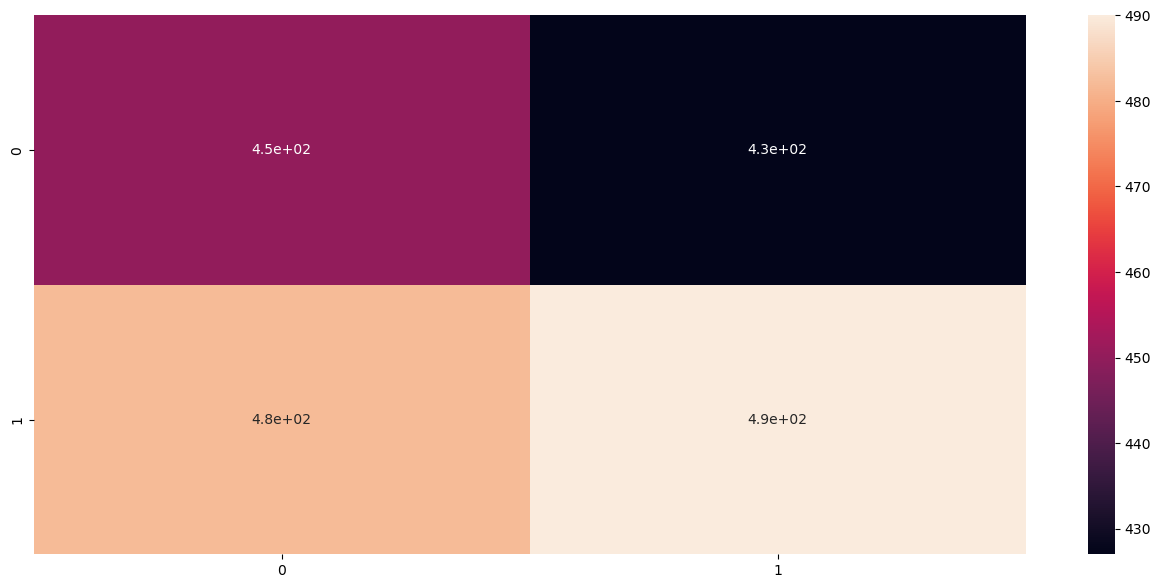

In [ ]:
# model predictions
train_preds1 =resnet_model.predict_generator(test_generator)#predicting test data using ResNet50
y_pred1 =list()
for i in train_preds1:
    y_pred1.append(round(i[0]))
from sklearn.metrics import confusion_matrix, cohen_kappa_score,accuracy_score
p=confusion_matrix(pf['DR'].astype("int"),y_pred1)
import seaborn as sns
plt.figure(figsize=(16, 7))
sns.heatmap(p,annot=True)#ploting confusion matrix
print("ResNet50 Accuracy score : %.3f" % accuracy_score(pf['DR'].astype('int'),y_pred1))#finding accuracy'''